<a href="https://colab.research.google.com/github/mrasifimran/Pythoncode/blob/main/San_Francisco_Crime_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing as prepro
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from collections import Counter

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [37]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

X=train.copy()

In [39]:
for i in ['DayOfWeek', 'PdDistrict', 'Address', 'Category']:
    X[i] = prepro.LabelEncoder().fit_transform(X[i])
    if i not in ['Category']:
        test[i] = prepro.LabelEncoder().fit_transform(test[i])

In [40]:
X['year'] = pd.to_datetime(X['Dates']).dt.year
X['month'] = pd.to_datetime(X['Dates']).dt.month
X['day'] = pd.to_datetime(X['Dates']).dt.day
X['hour'] = pd.to_datetime(X['Dates']).dt.hour
X['minute'] = pd.to_datetime(X['Dates']).dt.minute

test['year'] = pd.to_datetime(test['Dates']).dt.year
test['month'] = pd.to_datetime(test['Dates']).dt.month
test['day'] = pd.to_datetime(test['Dates']).dt.day
test['hour'] = pd.to_datetime(test['Dates']).dt.hour
test['minute'] = pd.to_datetime(test['Dates']).dt.minute

In [41]:
for i in [[6, 'month'], [8, 'hour'], [10, 'day']]:
    feature = i[1]
    bins = i[0]
    X[feature+' bin'] = np.floor_divide(X[feature], len(np.unique(X[feature]))/bins)

In [42]:
y = X['Category']
X = X.drop(['Descript', 'Resolution', 'Dates', 'Category'], axis=1)
test = test.drop(['Dates', 'Id'], axis=1)

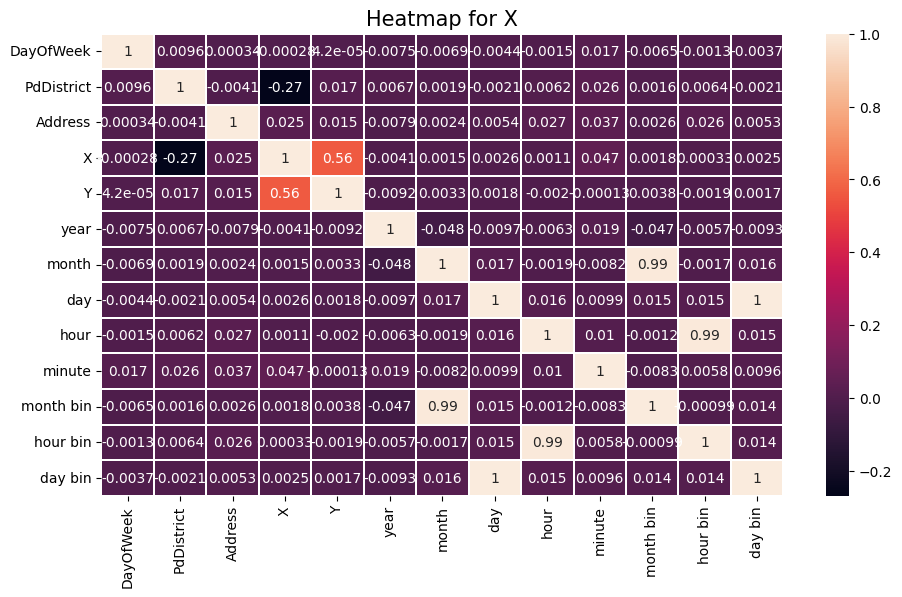

In [43]:
fig = plt.figure(figsize=(11, 6))
sns.heatmap(X.corr(), annot=True, linewidths=.1)
plt.title('Heatmap for X', fontsize=15)
plt.show()

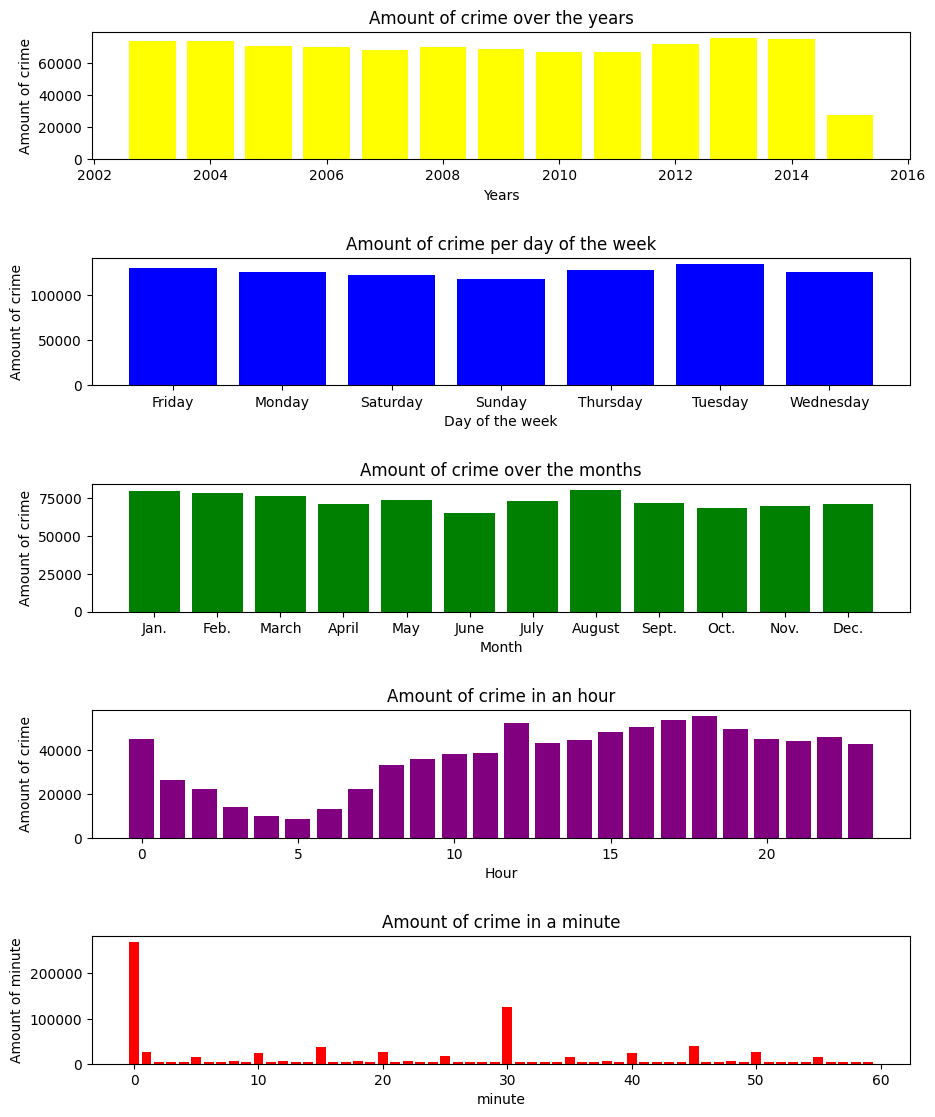

In [44]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(10, 12))
fig.tight_layout(pad=5.0)

count = Counter(X['year'])
ax1.bar(count.keys(), count.values(), color='yellow')
ax1.set_title('Amount of crime over the years')
ax1.set_ylabel('Amount of crime')
ax1.set_xlabel('Years')

count = Counter(X['DayOfWeek'])
ax2.bar(np.unique(train['DayOfWeek']), count.values(), color='blue')
ax2.set_title('Amount of crime per day of the week')
ax2.set_ylabel('Amount of crime')
ax2.set_xlabel('Day of the week')

count = Counter(X['month'])
ax3.bar(['Jan.', 'Feb.', 'March', 'April', 'May', 'June', 'July', 'August','Sept.','Oct.','Nov.','Dec.'],count.values(),color='green')
ax3.set_title('Amount of crime over the months')
ax3.set_ylabel('Amount of crime')
ax3.set_xlabel('Month')

count = Counter(X['hour'])
ax4.bar(count.keys(), count.values(), color='purple')
ax4.set_title('Amount of crime in an hour')
ax4.set_ylabel('Amount of crime')
ax4.set_xlabel('Hour')

count = Counter(X['minute'])
ax5.bar(count.keys(), count.values(), color='red')
ax5.set_title('Amount of crime in a minute')
ax5.set_ylabel('Amount of minute')
ax5.set_xlabel('minute')

plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 18))
fig.tight_layout(pad=17.0)

count = Counter(train['PdDistrict'])
data = (np.array(sorted(count.items(), key=lambda x:x[1], reverse=True)).T).tolist()
sns.barplot(data[0], data[1])
plt.title('Crime per neighbourhood')
plt.ylabel('Amount of crime')
plt.xlabel('Neighbourhood')

count = Counter(train['Category'])
data = (np.array(sorted(count.items(), key=lambda x:x[1])).T).tolist()
ax1.tick_params()
ax1.bar(data[0], data[1])
ax1.set_xticklabels(data[0], rotation=90)
ax1.set_title('Types of crime')
ax1.set_ylabel('Amount of crime')
plt.show()

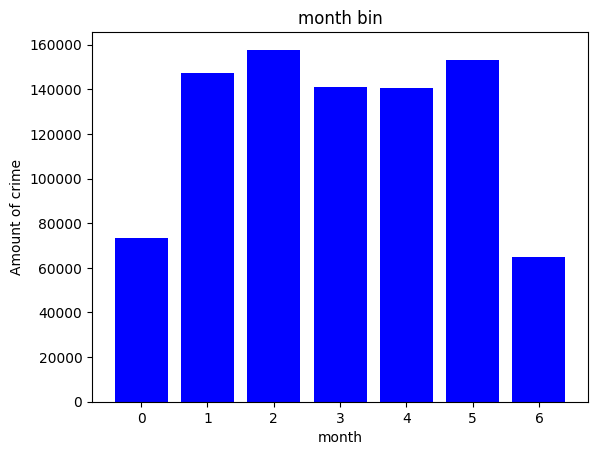

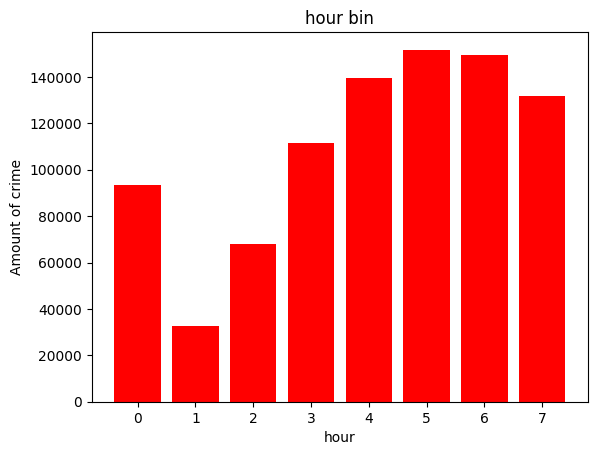

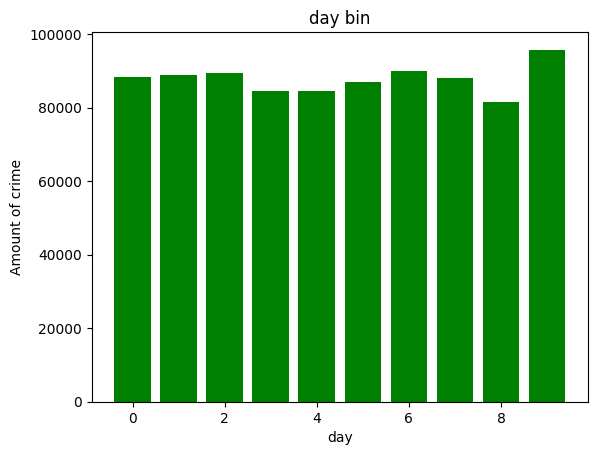

In [46]:
for i in [['month bin', 'blue'], ['hour bin', 'red'], ['day bin', 'green']]:
    count = Counter(X[i[0]])
    color = i[1]
    plt.bar(count.keys(), count.values(), color=color)
    plt.title(i[0])
    plt.ylabel('Amount of crime')
    plt.xlabel(i[0].split()[0])
    plt.show()

In [47]:
y = to_categorical(y)
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1, test_size=0.2)
X_train = prepro.StandardScaler().fit_transform(X_train)
X_val = prepro.StandardScaler().fit_transform(X_val)

In [ ]:
model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(X.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(39, activation='softmax'))

model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=100, steps_per_epoch=2195)

for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

Epoch 1/100
2195/2195 [==============================] - 23s 10ms/step - loss: 2.7120 - accuracy: 0.2052 - val_loss: 2.5611 - val_accuracy: 0.2321
Epoch 2/100
2195/2195 [==============================] - 17s 8ms/step - loss: 2.5434 - accuracy: 0.2367 - val_loss: 2.5232 - val_accuracy: 0.2417
Epoch 3/100
2195/2195 [==============================] - 12s 6ms/step - loss: 2.5140 - accuracy: 0.2439 - val_loss: 2.5040 - val_accuracy: 0.2479
Epoch 4/100
2195/2195 [==============================] - 11s 5ms/step - loss: 2.4962 - accuracy: 0.2478 - val_loss: 2.5011 - val_accuracy: 0.2426
Epoch 5/100
2195/2195 [==============================] - 11s 5ms/step - loss: 2.4820 - accuracy: 0.2510 - val_loss: 2.4903 - val_accuracy: 0.2456
Epoch 6/100
2195/2195 [==============================] - 17s 8ms/step - loss: 2.4780 - accuracy: 0.2525 - val_loss: 2.5050 - val_accuracy: 0.2365
Epoch 7/100
2195/2195 [==============================] - 12s 5ms/step - loss: 2.4718 - accuracy: 0.2545 - val_loss: 2.4971 